In [1]:
#importing python libs

import sympy as sym
sym.init_printing()

import numpy as np
from math import pi
import math
import matplotlib.pyplot as plt
from sympy import I, Matrix, symbols
from sympy.physics.quantum import TensorProduct, Dagger
import scipy.optimize
import scipy.integrate
import scipy.constants as const

#import qutip

from matplotlib.colors import Normalize as Norm

%load_ext cython
import time

In [35]:
#from sympy.physics.quantum import Commutator as comm
def comm(A,B):
    return A*B-B*A

In [2]:
#define some s pre/post operators

def spre(m):
    return TensorProduct(sym.eye(m.shape[0]),m)

def spost(m):
    return TensorProduct(m.T, sym.eye(m.shape[0]))

def collapse(c):
    tmp = Dagger(c)*c/2
    return spre(c)*spost(Dagger(c))-spre(tmp)-spost(tmp)


s13=Matrix([[0,0,1],[0,0,0],[0,0,0]])
s23=Matrix([[0,0,0],[0,0,1],[0,0,0]])
s12=Matrix([[0,1,0],[0,0,0],[0,0,0]])

s31=s13.T
s32=s23.T
s21=s12.T

s11 = s12*s21
s22 = s21*s12
s33 = s31*s13

In [320]:
delo,delm=sym.symbols('delta_o delta_mu', real=True) 
#delao, delam =sym.symbols('delta_a_o delta_a_mu') #detunings between atom and cavity
gamma13,gamma23,gamma2d,gamma3d,nbath,gammamu=sym.symbols('gamma_13 gamma_23 gamma_2d gamma_3d n_b gamma_mu', real=True, negative=False) #energy decay for atom levels
Omega=sym.symbols('Omega', real=False) #pump Rabi frequency
rho11, rho12, rho13, rho21, rho22, rho23, rho31, rho32, rho33=sym.symbols('rho_11 rho_12 rho_13 rho_21 rho_22 rho_23 rho_31 rho_32 rho_33') #Density matrix elements
a, b = sym.symbols('a b') #classical amplitudes of the optical and microwave fields
#ar,ai=sym.symbols('a_r a_i', real=True)
go, gm=sym.symbols('g_o, g_mu',real=False) #coupling strengths for optical and microwave fields
lam=sym.symbols('lambda')
Del= sym.symbols('Delta', real=True)

In [270]:
p = {}

p['deltamu'] = 0.
p['deltao'] = 0.


p['d13'] = 2e-32*math.sqrt(1/3)
p['d23'] = 2e-32*math.sqrt(2/3)
p['gamma13'] = p['d13']**2/(p['d13']**2+p['d23']**2)*1/11e-3
p['gamma23'] = p['d23']**2/(p['d13']**2+p['d23']**2)*1/11e-3
p['gamma2d'] = 1e6
p['gamma3d'] = 1e6
p['nbath'] = 20
p['gammamu'] = 1/(p['nbath']+1) * 1e3

p['go'] = 51.9  #optical coupling

p['No'] = 1.28e15 # number of atoms in the optical mode

p['deltac']=0 #detuning for 
p['kappaoi']=2*pi*7.95e6 # intrinsic loss for optical resonator
p['kappaoc']=2*pi*1.7e6 # coupling loss for optical resonator
#p['df']=0.1e6 # how small descretisation step to take when integrating over the 
            # inhomogeneous lines

p['mean_delam']=0
p['sd_delam']=2*pi*25e6/2.355  #microwave inhomogeneous broadening
                                #2.355is to turn FWHM into standard deviation
p['mean_delao']=0
p['sd_delao']=2*pi*170e6/2.355 #optical inhomogeneous broadening

p['kappami'] = 650e3*2*pi # intrinsic loss for microwave cavity
p['kappamc'] = 70e3*2*pi  # coupling loss for optical cavity
                        # this is for one of the two output ports
p['Nm'] = 2.22e16  #toal number of atoms
p['gm'] = 1.04 #coupling between atoms and microwave field

p['gammaoc']=2*pi*1.7e6
p['gammaoi']=2*pi*7.95e6
p['gammamc']=2*pi*70e3
p['gammami']=2*pi*650e3


muBohr=927.4009994e-26; # Bohr magneton in J/T in J* T^-1
p['mu12'] = 4.3803*muBohr # transition dipole moment for microwave cavity (J T^-1)

p['Lsample']=12e-3 # the length of the sample, in m
p['dsample']=5e-3 # the diameter of the sample, in m

p['fillfactor']=0.8 #microwave filling factor
p['freqmu'] = 5.186e9
p['freq_pump'] = 195113.36e9 #pump frequency
p['freqo']=p['freqmu']+p['freq_pump']

p['Lcavity_vac'] = 49.5e-3 # length of the vacuum part of the optical
                           # Fabry Perot (m)
p['Wcavity'] =  0.6e-3# width of optical resonator beam in sample (m)
p['nYSO'] = 1.76
p['Omega']=-492090.88755145477



In [271]:
def singular_test_bad(A):
    A_func=sym.lambdify((delo,delm,gamma13,gamma23,gamma2d,gamma3d,nbath,gammamu,Omega,go, gm,a,b),A)
    A_det=np.zeros(10,dtype=np.complex_)
    for ii in range(10):
        A_mat=A_func(np.random.randn()*1e6,np.random.rand()*1e6,np.random.rand(),np.random.rand(),np.random.rand(),np.random.rand(),np.random.rand(),np.random.rand(),np.random.rand(),np.random.rand(),np.random.rand(),np.random.rand(),np.random.rand())
        A_det[ii]=np.linalg.det(A_mat)
    if sum(A_det)==0:
        rval=0
    else:
        rval=A_det
    return rval

In [272]:
H=Omega*s32+gm*s21*b+go*s31*a
H=H+Dagger(H)
H=H+(delo)*s33+(delm)*s22

In [273]:
LH=-I*spre(H)+I*spost(H)
L21 = gammamu*(nbath+1)*collapse(s12)
L12 = gammamu*nbath*collapse(s21)
L32 = gamma23*collapse(s23)
L31 = gamma13*collapse(s13)
L22 = gamma2d*collapse(s22)
L33 = gamma3d*collapse(s33)

L=LH + L21 + L12 + L32 + L31 + L22 + L33
#L = L.row_insert(0,Matrix([[1,0,0,0,1,0,0,0,1]]))
#LH = LH.row_insert(0,Matrix([[1,0,0,0,1,0,0,0,1]]))

#L.row_del(1)

#define the density matrix in square and row form
#the row form is so the Liovillian in matrix form can be acted on it
rho = Matrix([[rho11,rho21,rho31],[rho12,rho22,rho32],[rho13,rho23,rho33]])
rho = 1*rho.T #because we are using "fortran" style matrix flatteneing
rho[:]
rhoflat = 1*rho.T 
rhoflat = rhoflat[:]

In [274]:
L0=L.subs({a:0,b:0})
La=L.subs({a:1,b:0})-L0
Lb=L.subs({a:0,b:1})-L0
LGamma=L-LH

In [275]:
H0=H.subs({a:0,b:0})
Ha=H.subs({a:1,b:0})-H0
Hb=H.subs({a:0,b:1})-H0
H1=a*Ha+b*Hb

In [276]:
Lambda= Matrix([[l1,0,0],[0,l2,0],[0,0,l3]])

In [277]:
Lambda*rho-rho*Lambda

⎡       0          λ₁⋅ρ₁₂ - λ₂⋅ρ₁₂   λ₁⋅ρ₁₃ - λ₃⋅ρ₁₃⎤
⎢                                                   ⎥
⎢-λ₁⋅ρ₂₁ + λ₂⋅ρ₂₁         0          λ₂⋅ρ₂₃ - λ₃⋅ρ₂₃⎥
⎢                                                   ⎥
⎣-λ₁⋅ρ₃₁ + λ₃⋅ρ₃₁  -λ₂⋅ρ₃₂ + λ₃⋅ρ₃₂         0       ⎦

In [278]:
La

⎡                __                                     ⎤
⎢  0     0    -ⅈ⋅gₒ    0    0    0    ⅈ⋅gₒ    0      0  ⎥
⎢                                                       ⎥
⎢  0     0      0      0    0    0      0    ⅈ⋅gₒ    0  ⎥
⎢                                                       ⎥
⎢-ⅈ⋅gₒ   0      0      0    0    0      0     0    ⅈ⋅gₒ ⎥
⎢                                                       ⎥
⎢                                 __                    ⎥
⎢  0     0      0      0    0  -ⅈ⋅gₒ    0     0      0  ⎥
⎢                                                       ⎥
⎢  0     0      0      0    0    0      0     0      0  ⎥
⎢                                                       ⎥
⎢  0     0      0    -ⅈ⋅gₒ  0    0      0     0      0  ⎥
⎢                                                       ⎥
⎢  __                                                 __⎥
⎢ⅈ⋅gₒ    0      0      0    0    0      0     0    -ⅈ⋅gₒ⎥
⎢                                                       ⎥
⎢         __  

In [279]:
Lb

⎡           ___                                                 ⎤
⎢  0     -ⅈ⋅gₘᵤ    0    ⅈ⋅gₘᵤ     0       0      0       0     0⎥
⎢                                                               ⎥
⎢-ⅈ⋅gₘᵤ    0       0      0     ⅈ⋅gₘᵤ     0      0       0     0⎥
⎢                                                               ⎥
⎢  0       0       0      0       0     ⅈ⋅gₘᵤ    0       0     0⎥
⎢                                                               ⎥
⎢  ___                             ___                          ⎥
⎢ⅈ⋅gₘᵤ     0       0      0     -ⅈ⋅gₘᵤ    0      0       0     0⎥
⎢                                                               ⎥
⎢          ___                                                  ⎥
⎢  0     ⅈ⋅gₘᵤ     0    -ⅈ⋅gₘᵤ    0       0      0       0     0⎥
⎢                                                               ⎥
⎢                  ___                                          ⎥
⎢  0       0     ⅈ⋅gₘᵤ    0       0       0      0       0     0⎥
⎢         

In [280]:
L0

⎡-γₘᵤ⋅n_b                     0                                     0         
⎢                                                                             
⎢                   γ_2d   γₘᵤ⋅n_b   γₘᵤ⋅(n_b + 1)                    _       
⎢   0      -ⅈ⋅δₘᵤ - ──── - ─────── - ─────────────                 -ⅈ⋅Ω       
⎢                    2        2            2                                  
⎢                                                                             
⎢                                                           γ₁₃   γ₂₃   γ_3d  
⎢   0                       -ⅈ⋅Ω                    -ⅈ⋅δₒ - ─── - ─── - ──── -
⎢                                                            2     2     2    
⎢                                                                             
⎢                                                                             
⎢   0                         0                                     0         
⎢                                                   

In [281]:
LGamma

⎡-γₘᵤ⋅n_b                 0                               0                   
⎢                                                                             
⎢            γ_2d   γₘᵤ⋅n_b   γₘᵤ⋅(n_b + 1)                                   
⎢   0      - ──── - ─────── - ─────────────               0                   
⎢             2        2            2                                         
⎢                                                                             
⎢                                              γ₁₃   γ₂₃   γ_3d   γₘᵤ⋅n_b     
⎢   0                     0                  - ─── - ─── - ──── - ───────     
⎢                                               2     2     2        2        
⎢                                                                             
⎢                                                                            γ
⎢   0                     0                               0                - ─
⎢                                                   

In [282]:
L0_fun=sym.lambdify((delo,delm,gamma13, gamma23, gamma2d, gamma3d, nbath,gammamu,Omega,go,gm),L0)
La_fun=sym.lambdify((go,gm),La)
Lb_fun=sym.lambdify((go,gm),Lb)
LGamma_fun=sym.lambdify((gamma13, gamma23, gamma2d, gamma3d, nbath,gammamu,Omega,go,gm),LGamma)

In [283]:
def rho0_fun(deloval,delmval,p):
    L0_mat=L0_fun(deloval,delmval,p['gamma13'],p['gamma23'],p['gamma2d'],p['gamma3d'], p['nbath'],p['gammamu'],p['Omega'],p['go'],p['gm'])
    L0_mat[0,:]=np.array([[1,0,0,0,1,0,0,0,1]])
    rho = np.linalg.solve(L0_mat.astype('complex128'),np.matrix([[1,0,0,0,0,0,0,0,0]]).T)
    return rho#np.reshape(rho,(3,3),order='F')

In [284]:
rho0_fun(0,0,p).flatten('F')

matrix([[ 0.35105258+0.0000000e+00j,  0.        -0.0000000e+00j,
          0.        -0.0000000e+00j,  0.        -0.0000000e+00j,
          0.32450418+0.0000000e+00j, -0.        +2.9968895e-05j,
          0.        -0.0000000e+00j,  0.        -2.9968895e-05j,
          0.32444324+0.0000000e+00j]])

In [285]:
Matrix(rho0_fun(10e6,-50e6,p))

⎡0.401001398466616 + 5.00545148412344e-16⋅ⅈ ⎤
⎢                                           ⎥
⎢                     0                     ⎥
⎢                                           ⎥
⎢                     0                     ⎥
⎢                                           ⎥
⎢                     0                     ⎥
⎢                                           ⎥
⎢0.375121952910365 + 4.28164109045909e-16⋅ⅈ ⎥
⎢                                           ⎥
⎢0.00124009575348079 + 2.06795361557822e-5⋅ⅈ⎥
⎢                                           ⎥
⎢                     0                     ⎥
⎢                                           ⎥
⎢0.00124009575348079 - 2.0679536155762e-5⋅ⅈ ⎥
⎢                                           ⎥
⎣0.223876648623019 - 8.01001675793626e-16⋅ⅈ ⎦

In [286]:
def rhoa_fun(deloval,delmval,rho0,p):
    L0_mat=L0_fun(deloval,delmval,p['gamma13'],p['gamma23'],p['gamma2d'],p['gamma3d'], p['nbath'],p['gammamu'],p['Omega'],p['go'],p['gm'])
    La_mat=La_fun(p['go'],p['gm'])
    return np.matrix(np.linalg.inv(L0_mat))*np.matrix(La_mat)*np.matrix(rho0)#p.matrix(np.reshape(rho0,(9,1)))

In [287]:
def rhob_fun(deloval,delmval,rho0,p):
    L0_mat=L0_fun(deloval,delmval,p['gamma13'],p['gamma23'],p['gamma2d'],p['gamma3d'], p['nbath'],p['gammamu'],p['Omega'],p['go'],p['gm'])
    Lb_mat=Lb_fun(p['go'],p['gm'])
    return np.matrix(np.linalg.inv(L0_mat))*np.matrix(Lb_mat)*np.matrix(rho0)#p.matrix(np.reshape(rho0,(9,1)))

In [288]:
rho0=rho0_fun(10e6,-50e6,p)
rhoa=rhoa_fun(10e6,-50e6,rho0,p)
rhob=rhob_fun(10e6,-50e6,rho0,p)

Matrix([rho0,rhoa,rhob,rhoflat])

⎡[[0.401001398466616 + 5.00545148412344e-16⋅ⅈ]]                        [[0]]  
⎢                                                                             
⎢                    [[0]]                        [[-7.73776462434961e-9 - 3.9
⎢                                                                             
⎢                    [[0]]                       [[-5.36713149675307e-10 + 5.4
⎢                                                                             
⎣                     ρ₁₁                                               ρ₂₁   

                                             [[0]]                            
                                                                              
526696981842e-10⋅ⅈ]]    [[9.16601369569579e-7 + 4.58584318052128e-8⋅ⅈ]]    [[-
                                                                              
7243022751351e-12⋅ⅈ]]  [[-1.54898900621029e-10 - 9.63440371051748e-12⋅ⅈ]]  [[-
                                                   

In [289]:
rho0=rho0_fun(10e6,-50e6,p)
rhoa=rhoa_fun(10e6,-50e6,rho0,p)
rhob=rhob_fun(10e6,-50e6,rho0,p)

Matrix([rho0,rhoa,rhob,rhoflat])

⎡[[0.401001398466616 + 5.00545148412344e-16⋅ⅈ]]                        [[0]]  
⎢                                                                             
⎢                    [[0]]                        [[-7.73776462434961e-9 - 3.9
⎢                                                                             
⎢                    [[0]]                       [[-5.36713149675307e-10 + 5.4
⎢                                                                             
⎣                     ρ₁₁                                               ρ₂₁   

                                             [[0]]                            
                                                                              
526696981842e-10⋅ⅈ]]    [[9.16601369569579e-7 + 4.58584318052128e-8⋅ⅈ]]    [[-
                                                                              
7243022751351e-12⋅ⅈ]]  [[-1.54898900621029e-10 - 9.63440371051748e-12⋅ⅈ]]  [[-
                                                   

In [290]:
np.linalg.inv(L0_fun(10e6,-50e6,p['gamma13'],p['gamma23'],p['gamma2d'],p['gamma3d'], p['nbath'],p['gammamu'],p['Omega'],p['go'],p['gm']))

array([[ 1.34861126e+02-2.90846831e+16j,  0.00000000e+00-0.00000000e+00j,
         0.00000000e+00-0.00000000e+00j,  0.00000000e+00-0.00000000e+00j,
         1.34862176e+02-2.90846831e+16j, -6.39776682e-05-1.06687609e-06j,
         0.00000000e+00-0.00000000e+00j, -6.39776682e-05+1.06687609e-06j,
         1.34804228e+02-2.90846831e+16j],
       [ 0.00000000e+00-0.00000000e+00j, -2.00659912e-10-1.99883283e-08j,
         3.92590366e-11-9.81642423e-10j,  0.00000000e+00-0.00000000e+00j,
         0.00000000e+00-0.00000000e+00j,  0.00000000e+00-0.00000000e+00j,
         0.00000000e+00-0.00000000e+00j,  0.00000000e+00-0.00000000e+00j,
         0.00000000e+00-0.00000000e+00j],
       [-0.00000000e+00+0.00000000e+00j,  3.92590366e-11-9.81642423e-10j,
        -4.98836978e-09+9.97020156e-08j, -0.00000000e+00+0.00000000e+00j,
        -0.00000000e+00+0.00000000e+00j, -0.00000000e+00+0.00000000e+00j,
        -0.00000000e+00+0.00000000e+00j, -0.00000000e+00+0.00000000e+00j,
        -0.00000000e+00+0.00

In [291]:
(Matrix(np.linalg.inv(L0_fun(10e6,-50e6,p['gamma13'],p['gamma23'],p['gamma2d'],p['gamma3d'], p['nbath'],p['gammamu'],p['Omega'],p['go'],p['gm'])))*Matrix(La_fun(p['go'],p['gm']))*Matrix(rho0_fun(10e6,-50e6,p).flatten('F').T)).T

[0  -51.9⋅ⅈ⋅(3.92590366435531e-11 - 9.81642423462121e-10⋅ⅈ)⋅(0.401001398466616
 + 5.00545148412344e-16⋅ⅈ) + 51.9⋅ⅈ⋅(-2.00659911972945e-10 - 1.9988328337406e-
8⋅ⅈ)⋅(0.00124009575348079 - 2.0679536155762e-5⋅ⅈ) + 51.9⋅ⅈ⋅(3.92590366435531e-
11 - 9.81642423462121e-10⋅ⅈ)⋅(0.223876648623019 - 8.01001675793626e-16⋅ⅈ)  51.
9⋅ⅈ⋅(-4.98836978288254e-9 + 9.97020155658876e-8⋅ⅈ)⋅(0.223876648623019 - 8.0100
1675793626e-16⋅ⅈ) + 51.9⋅ⅈ⋅(3.92590366435531e-11 - 9.81642423462121e-10⋅ⅈ)⋅(0.
00124009575348079 - 2.0679536155762e-5⋅ⅈ) - 51.9⋅ⅈ⋅(-4.98836978288254e-9 + 9.9
7020155658876e-8⋅ⅈ)⋅(0.401001398466616 + 5.00545148412344e-16⋅ⅈ)  -51.9⋅ⅈ⋅(3.9
2590366435531e-11 + 9.81642423462121e-10⋅ⅈ)⋅(0.223876648623019 - 8.01001675793
626e-16⋅ⅈ) - 51.9⋅ⅈ⋅(-2.00659911972945e-10 + 1.9988328337406e-8⋅ⅈ)⋅(0.00124009
575348079 + 2.06795361557822e-5⋅ⅈ) + 51.9⋅ⅈ⋅(3.92590366435531e-11 + 9.81642423
462121e-10⋅ⅈ)⋅(0.401001398466616 + 5.00545148412344e-16⋅ⅈ)  0  0  51.9⋅ⅈ⋅(-4.9
8836978288254e-9 - 9.97020155658876e-8⋅ⅈ)⋅(0.4010013

In [292]:

testm=np.random.rand(3,3)
np.matrix(testm)*np.matrix(np.linalg.inv(testm))

matrix([[ 1.00000000e+00,  5.29195282e-17,  7.57059327e-17],
        [-2.49817704e-17,  1.00000000e+00,  5.38643236e-17],
        [-1.21752099e-17,  4.61230886e-17,  1.00000000e+00]])

In [293]:
np.random.rand()

In [343]:
rho_ou=sym.simplify(L0.nullspace()[0])
rho_ou=(rho_ou.subs({2*I*delo:2*I*delm+2*I*Del}))
rho_ou=sym.simplify(rho_ou)
rho_ou0=sym.simplify(rho_ou.subs({Del:0}))
rho_ou1=sym.simplify((rho_ou-rho_ou0)/Del).subs({Del:0})
rho_ou2=sym.simplify((rho_ou-rho_ou1*Del-rho_ou0)/Del**2)
rho_ou, rho_ou0, rho_ou1, rho_ou2

⎛                                                                             
⎜⎡                                                                            
⎜⎢- γₘᵤ⋅(γ₁₃ + γ₂₃)⋅(n_b + 1)⋅(2⋅ⅈ⋅Δ + γ₁₃ + γ₂₃ + γ_2d + γ_3d + γₘᵤ⋅(n_b + 1)
⎜⎢────────────────────────────────────────────────────────────────────────────
⎜⎢                                                                            
⎜⎢                                                                            
⎜⎢                                                                            
⎜⎢                                                                            
⎜⎢                                                                            
⎜⎢                                                                            
⎜⎢                                                                            
⎜⎢                                                                            
⎜⎢                                                  

In [350]:
rho0=rho0_fun(10e6,-50e6,p)
rhoa=sym.simplify(rhoa_fun(10e6,-50e6,rho_ou2,p))
rhob=sym.simplify(rhob_fun(10e6,-50e6,rho_ou2,p))

Matrix([rho0,rhoa,rhob,rhoflat])

⎡[[0.401001398466616 + 5.00545148412344e-16⋅ⅈ]]                               
⎢                                                                             
⎢                                                                 -(5.09472417
⎢                      0                                          ────────────
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                1.0⋅(-2.07878614709022e-8⋅γ₁₃
⎢                      0                         ─────────────────────────────
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎣                     ρ₁₁                           

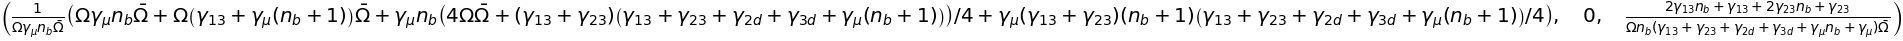

In [345]:
rho0norm=sym.simplify(rho_ou0[0]+rho_ou0[4]+rho_ou0[8])
rho1norm=sym.simplify(rho_ou1[0]+rho_ou1[4]+rho_ou1[8])
rho2norm=sym.simplify(rho_ou2[0]+rho_ou2[4]+rho_ou2[8])
rho0norm, rho1norm,rho2norm

In [335]:
rho_ou0

⎡                                                                     2     ⎛ 
⎢- γₘᵤ⋅(γ₁₃ + γ₂₃)⋅(n_b + 1)⋅(γ₁₃ + γ₂₃ + γ_2d + γ_3d + γₘᵤ⋅(n_b + 1))  + 2⋅⎝2
⎢─────────────────────────────────────────────────────────────────────────────
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

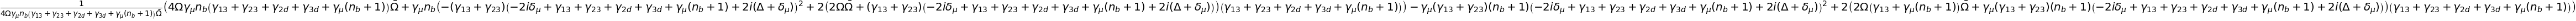

In [328]:
sym.simplify((rho_simp[0]+rho_simp[4] +rho_simp[8]).subs({delo:delm+Del}))

In [306]:
rhoflat[0], rhoflat[4], rhoflat[8]

In [310]:
sym.simplify(rho_simp/sym.simplify(rho_simp[0]+rho_simp[4] +rho_simp[8]))

⎡                                                                             
⎢                                                                             
⎢─────────────────────────────────────────────────────────────────────────────
⎢                                                      _           ⎛          
⎢4⋅Ω⋅γₘᵤ⋅n_b⋅(γ₁₃ + γ₂₃ + γ_2d + γ_3d + γₘᵤ⋅(n_b + 1))⋅Ω - γₘᵤ⋅n_b⋅⎝(γ₁₃ + γ₂₃
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

In [316]:
L0.pinv()

NotImplementedError: Rank-deficient matrices are not yet supported.